# 2. Feature Selection & Cleaning Pipeline

Scope:
- Load an EEG features superset and prepare a features subset suitable for ML training or prediction
- For an entire EEG study with multiple sibjects
- Using Scikit-Learn transformers and pipeline for a repeatable process

The Pipeline Stages:
- TBD


## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1



# Imports & Utilities

In [1]:
# General imports
import os
import gc
from datetime import datetime
from pprint import pprint
import time
import pickle

import math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ML Prep
# import sklearn
# sklearn.set_config(display='diagram')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# ML Train
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Utility function to establish relative paths for a given folder
def get_folder_path(folder_name, data_folder='Data'):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Directory not found: {folder_path}')  
    return folder_path

# Utility function to create a new folder path, if not exists
def make_folder_path(folder_name, data_folder='Data', exists_ok=True):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if os.path.exists(folder_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {folder_path}")
    else:
        os.makedirs(folder_path)
    return folder_path

 # Utility function to extend an existing folder path with a subfolder
def extend_folder_path(base_folder, subfolder, exists_ok=True):
    if not os.path.isdir(base_folder):
        raise FileNotFoundError(f'Parent directory not found: {base_folder}')
    extended_path = os.path.join(base_folder, subfolder)
    if os.path.exists(extended_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {extended_path}")
    else:
        os.makedirs(extended_path)
    return extended_path

# Utility function to check for the existence of a file in a given folder
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path


# Classes & Functions

## Features Inspection Utilities

In [3]:
# Quick Summary of the Features 
def features_summary(features_df):

    # Shape and key subject features, channels
    print(f'Features Shape: {features_df.shape}')
    subject_info_plot(features_df)
    channels_check(features_df)

    # Aperiodic and periodic components distributions
    aperiodic_components_plot(features_df)
    periodic_components_plot(features_df)
    fit_error_plot(features_df)

In [4]:
# Plots for subject info
def subject_info_plot(features_df):

    fig, axes = plt.subplots(1, 3, figsize=(16, 6))

    # PD histogram
    axes[0].hist(features_df['pd'].dropna(), bins=3, color='skyblue', edgecolor='black')
    axes[0].set_title('PD')
    axes[0].set_xlabel('PD')
    axes[0].set_ylabel('Count')

    # Gender histogram
    axes[1].hist(features_df['gender'].map({'M': 0, 'F': 1}), bins=2, color='skyblue', edgecolor='black', rwidth=0.8)
    axes[1].set_title('Gender (0=M, 1=F)')
    axes[1].set_xlabel('Gender')
    axes[1].set_ylabel('Count')
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['M', 'F'])

    # Age boxplot
    axes[2].boxplot(features_df['age'].dropna())
    axes[2].set_title('Age')
    axes[2].set_ylabel('Age')
    axes[2].set_xticks([1])
    axes[2].set_xticklabels(['Subjects'])

    plt.tight_layout()
    plt.show()


In [5]:
# Summary of channels
def channels_check(features_df, expected_channels = 63):

    from collections import Counter

     # Get the max number of channels all subjects
    chn_cols = [col for col in features_df.columns if col.startswith('chn_')]
    chn_numbers = set([col.split('_')[1] for col in chn_cols if col.split('_')[1].isdigit()])
    num_channels = len(chn_numbers)

    # Get the number of channels with periodic components
    exponent_cols = [col for col in chn_cols if col.endswith('exponent')]
    # num_exp_channels = len(exponent_cols)
    summary = []
    for idx, row in features_df.iterrows():
        subject_id = row['subject_id']

        # Channels With Peaks & difference with expected
        exponents = row[exponent_cols].dropna().values
        num_channels = len(exponents)
        chann_diff = num_channels - expected_channels
        if chann_diff != 0:
            summary.append({
                'subject_id': row['subject_id'],
                'channels': num_channels,
                'difference': chann_diff,
                })
            
    subject_counts = Counter([entry['channels'] for entry in summary])
    print(f'Subjects Channel Counts')
    print(f'- Expected {expected_channels}: {len(features_df) - len(summary)}')
    print(f'- Differences: {dict(subject_counts)}')
    

In [6]:
# Box plot of aperiodic components
def aperiodic_components_plot(features_df):

    # Extract all columns for offset and exponent & stack
    offset_cols = [col for col in features_df.columns if col.endswith('_offset')]
    exponent_cols = [col for col in features_df.columns if col.endswith('_exponent')]
    offset_values = features_df[offset_cols].values.flatten()
    exponent_values = features_df[exponent_cols].values.flatten()

    # Remove NaNs
    offset_values = offset_values[~np.isnan(offset_values)]
    exponent_values = exponent_values[~np.isnan(exponent_values)]

    # Box plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle('Aperiodic Features Distribution Across Subjects')

    axes[0].boxplot(offset_values)
    # axes[0].set_ylabel('Offset Value')
    axes[0].set_xticks([1])
    axes[0].set_xticklabels(['Offset'], fontsize=12)

    axes[1].boxplot(exponent_values)
    # axes[1].set_ylabel('Exponent Value')
    axes[1].set_xticks([1])
    axes[1].set_xticklabels(['Exponent'])

    plt.tight_layout()
    plt.show()

In [7]:
# Box plot of periodic components
def periodic_components_plot(features_df):
    
    # Extract all columns for cf, pw, bw & stack
    cf_cols = [col for col in features_df.columns if '_cf_' in col]
    pw_cols = [col for col in features_df.columns if '_pw_' in col]
    bw_cols = [col for col in features_df.columns if '_bw_' in col]

    cf_values = features_df[cf_cols].values.flatten()
    cf_values = cf_values[~np.isnan(cf_values)]
    pw_values = features_df[pw_cols].values.flatten()
    pw_values = pw_values[~np.isnan(pw_values)]
    bw_values = features_df[bw_cols].values.flatten()
    bw_values = bw_values[~np.isnan(bw_values)]

    # Bosplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    fig.suptitle('Periodic Features Distribution Across Subjects', fontsize=16)

    axes[0].boxplot(cf_values)
    # axes[0].set_ylabel('CF Value')
    axes[0].set_xticks([1])
    axes[0].set_xticklabels(['CF'])

    axes[1].boxplot(pw_values)
    # axes[1].set_ylabel('PW Value')
    axes[1].set_xticks([1])
    axes[1].set_xticklabels(['PW'])

    axes[2].boxplot(bw_values)
    # axes[2].set_ylabel('BW Value')
    axes[2].set_xticks([1])
    axes[2].set_xticklabels(['BW'])

    plt.tight_layout()

In [8]:
# Box plot of fit measures
def fit_error_plot(features_df):

    # Collect all r_squared and error columns & stack
    r2_cols = [col for col in features_df.columns if col.endswith('r_squared')]
    error_cols = [col for col in features_df.columns if col.endswith('error')]
    r2_values = features_df[r2_cols].values.flatten()
    r2_values = r2_values[~np.isnan(r2_values)]
    error_values = features_df[error_cols].values.flatten()
    error_values = error_values[~np.isnan(error_values)]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Fit Measures Distributions Across Subjects')

    axes[0].boxplot(r2_values)
    # axes[0].set_title('r_squared')
    # axes[0].set_ylabel('Value')
    axes[0].set_xticks([1])
    axes[0].set_xticklabels(['r_squared'])

    axes[1].boxplot(error_values)
    # axes[1].set_title('error')
    # axes[1].set_ylabel('Value')
    axes[1].set_xticks([1])
    axes[1].set_xticklabels(['error'])

    plt.tight_layout()
    plt.show()

# Establish Features Extraction Pipeline


## Setup Parameters etc

In [9]:
# ML Features Pipeline Run Define & Setup
#

# -----------------------------------------------------------------------
# Study Details
study_name = 'IOWA_Rest'
dataset_ref = 'ds004584-1.0.0'
eeg_run_folder = 'EEG_Processing_ds004584-1.0.0_20250619_no_preprocess'
# study_name = 'UNM_Oddball'
# dataset_ref = 'ds003490-1.1.0'
# eeg_run_id = '20250618'

# Run/Test Mode
test_mode = False

# Execution Parameters
run_summary = 'full_pipeline'
ml_params = {'models': 'none'
            }
# -----------------------------------------------------------------------

# Get existing study details, if exists
study_folder_path = get_folder_path('Study_' + study_name)
study_info_df = pd.read_pickle(study_folder_path + '/study_inf_df.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df
eeg_processing_results_path = study_info_df.loc[0, 'eeg_processing_results_path']
ml_training_results_path = study_info_df.loc[0, 'ml_training_results_path']

# Get EEG results files
eeg_results_run_path = os.path.join(eeg_processing_results_path, eeg_run_folder)
if not os.path.isdir(eeg_results_run_path):
    raise FileNotFoundError(f'Directory not found: {eeg_results_run_path}')
eeg_features_superset_file_path = get_file_path(eeg_results_run_path, 'eeg_results_features_superset_df.pkl')
eeg_run_parameters_file_path = get_file_path(eeg_results_run_path, 'eeg_run_params_df.pkl')

# Establish a new ML Training Run
current_date = datetime.now().strftime('%Y%m%d')
ml_run_id = f'ML_Training_{dataset_ref}_{current_date}_{run_summary}'
ml_training_run_path = extend_folder_path(ml_training_results_path, ml_run_id, exists_ok=False)

# Create run df and save
ml_run_params_df = pd.DataFrame({
    'ml_run_id': [ml_run_id],
    'study_name': [study_name],
    'dataset_ref': [dataset_ref],
    'ml_params': [ml_params]
})
ml_run_params_df.to_pickle(ml_training_run_path + '/ml_run_params_df.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
else:
    VERBOSE = False

del current_date, eeg_processing_results_path, eeg_run_folder, eeg_results_run_path, ml_training_results_path, run_summary

## Features Superset Load & Data Inspection

In [10]:
# Load the EEG features superset
#

# Get features superset created after EEG processing
features_superset_df = pd.read_pickle(eeg_features_superset_file_path, compression='zip')


Features Shape: (149, 2248)


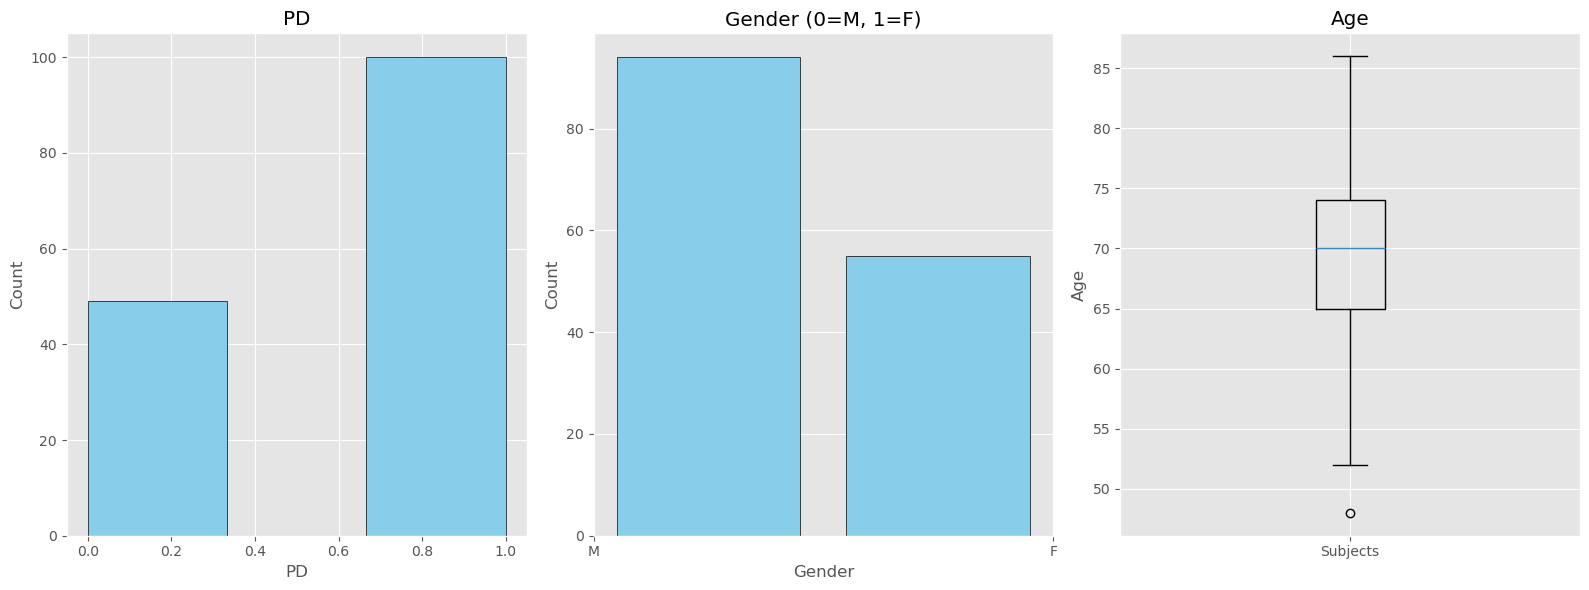

Subjects Channel Counts
- Expected 63: 119
- Differences: {64: 29, 66: 1}


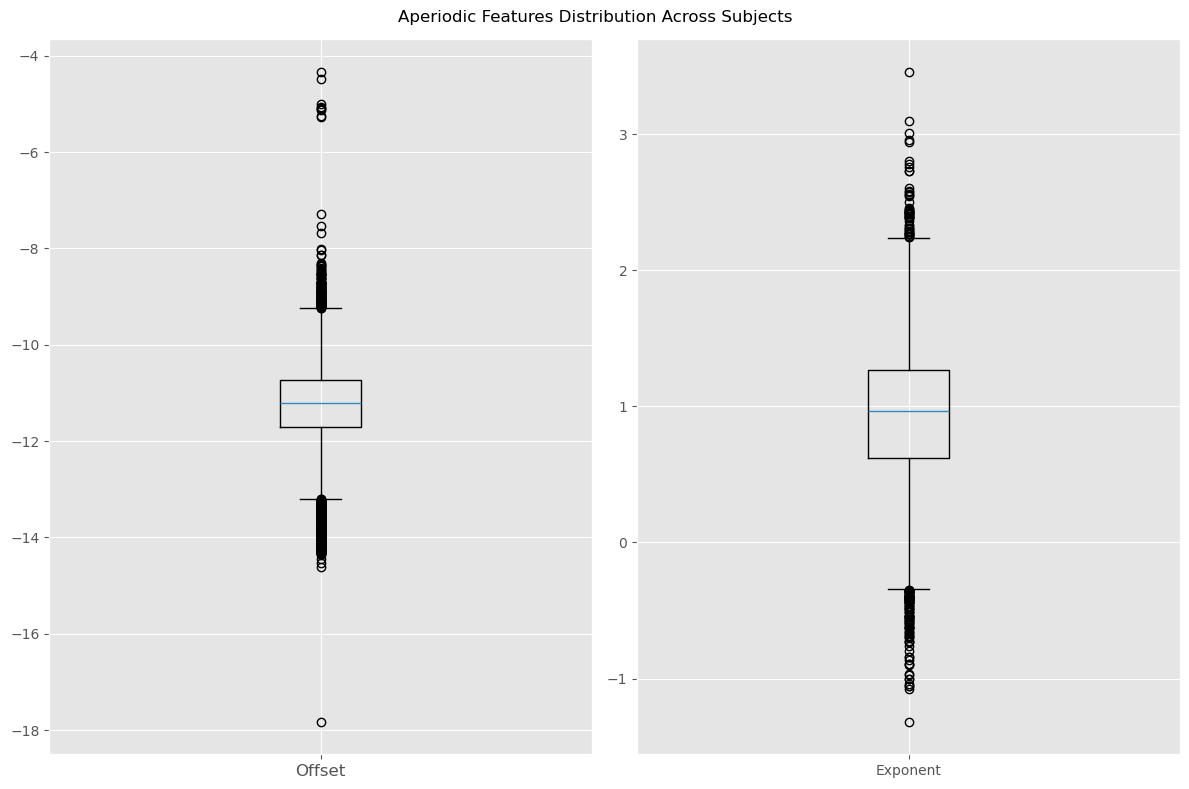

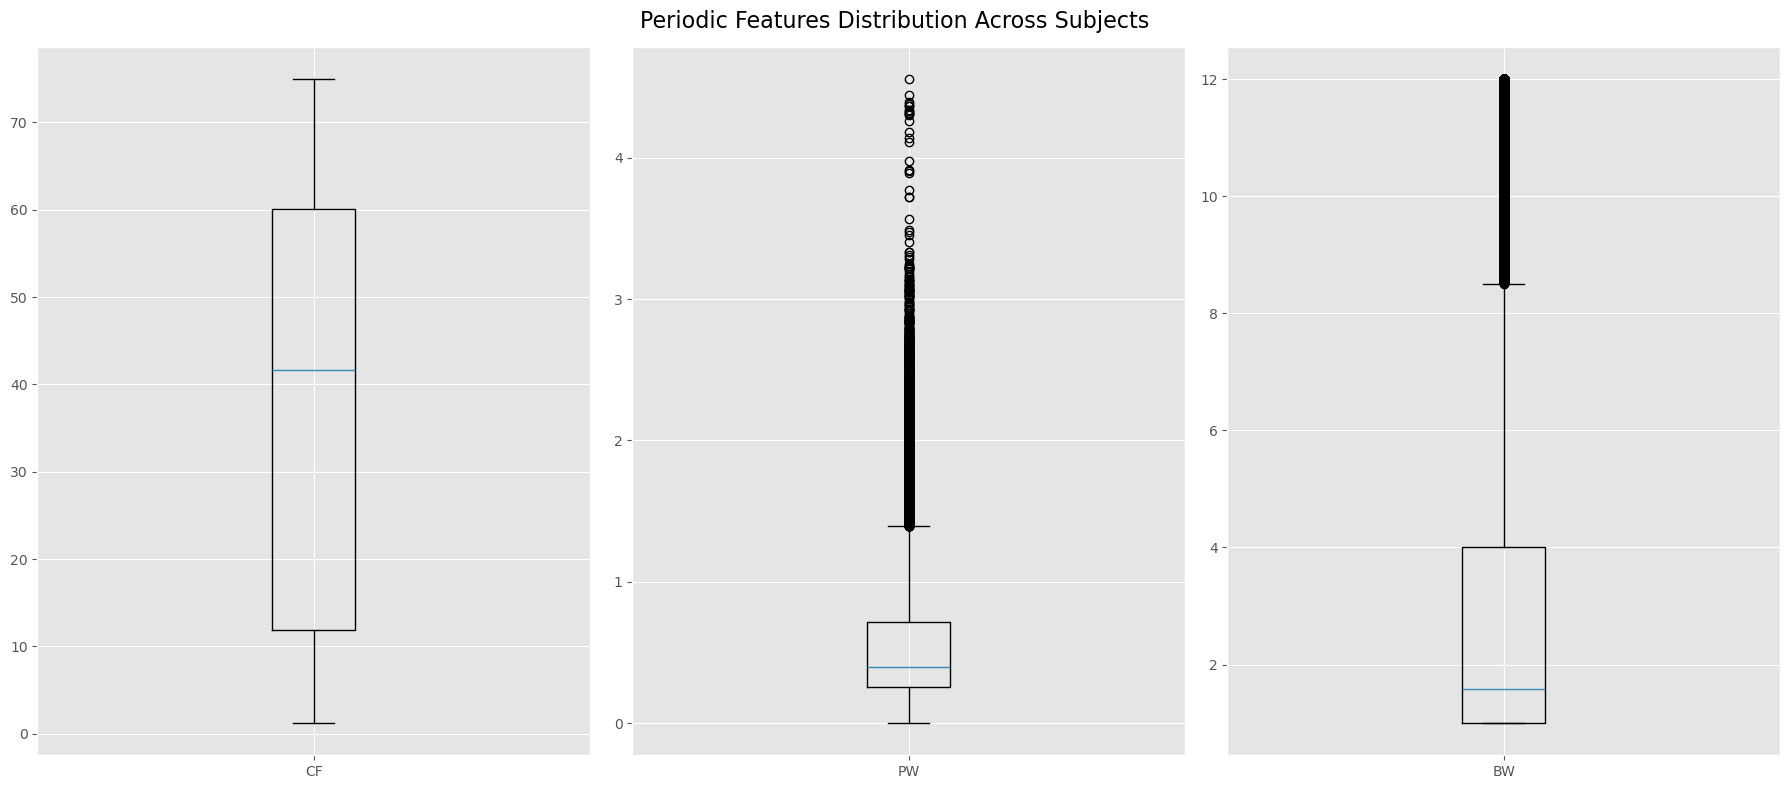

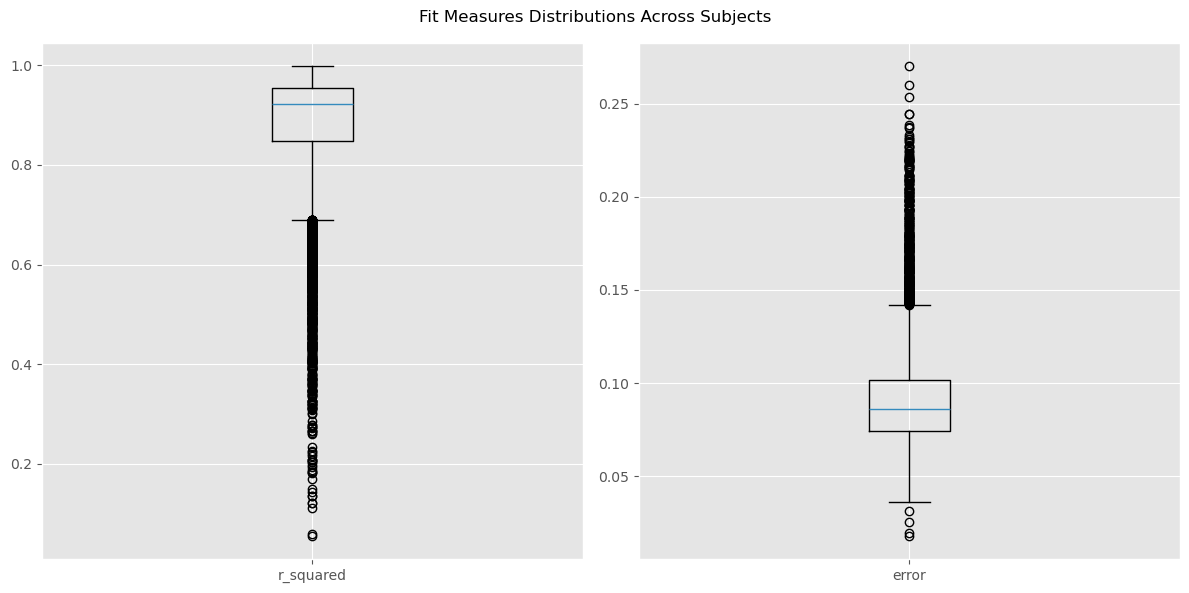

In [11]:
# Inspect Data Before Cleaning
#

features_summary(features_superset_df)

## Create Data Pipeline

In [12]:
# Establish a data cleaning pipeline
#

# Seperate X features and y target
target_name = 'pd'
feature_names = features_superset_df.columns[features_superset_df.columns != target_name]
X = features_superset_df[feature_names].copy()
y = features_superset_df[target_name].copy()

# Data Split : Training & Test, 80:20. NB cross-validation will be perfoermed using Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Features/Columns to drop
features_drop_subj = ['subject_id']
# Channels to drop: r2, error and anything over max channels eg chn66
max_channel = 62
channels_columns_all = [col for col in features_superset_df.columns if 'chn_' in col]
features_drop_r2 = [col for col in channels_columns_all if col.endswith('r_squared')]
features_drop_error = [col for col in channels_columns_all if col.endswith('error')]
features_drop_extra_channels = [col for col in channels_columns_all if int(col.split('_')[1]) > max_channel]
features_drop_channels = features_drop_r2 + features_drop_error + features_drop_extra_channels
channel_columns_remaining = [col for col in channels_columns_all if col not in features_drop_channels]

# Numerical and categorical values to transform
features_num = ['age']
features_cat = ['gender']
features_channels = channel_columns_remaining

# Pipeline to impute and then scale the channels
channel_pipeline = Pipeline([
    #('impute', IterativeImputer(max_iter=10, random_state=42)),
    ('impute', SimpleImputer(strategy='mean')),
    ('scale_chns', RobustScaler())
    ])

# Define the transformations for the ColumnTransformer
data_transformations = [
    ('drop', 'drop', features_drop_subj + features_drop_channels),
    ('encode_cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), features_cat),
    ('scale_num', StandardScaler(), features_num),
    ('prep_chans', channel_pipeline, features_channels)
    #('impute', IterativeImputer(max_iter=10, random_state=42), features_channels),
    # ('impute', SimpleImputer(strategy='mean'), features_channels),
    # ('scale_chns', RobustScaler(), features_channels),  # RobustScaler as not anormal dist, plus large outliers
    ]
data_preprocessing = ColumnTransformer(
    transformers = data_transformations,
    remainder = 'passthrough'
    )

# Put into a pipeline, purely for saving and later use
features_extraction_pl = Pipeline([
    ('features_extraction', data_preprocessing)
])

# Fit all the transformations to the features
# data_preprocessing.fit(X_train)
features_extraction_pl.fit(X_train)


# TODO: What is the ML training impact if r2, error not dropped?
# TODO: Approach to handling missing channel data, eg when not all 10 periodic peaks are present: eg more complex such as MICE?
# TODO: IterativeImputer / MICE is time consuming
# TODO: RobustScaler for channels as not anormal dist, plus large outliers
# TODO: still large outliers for offset, exponent, CF, PW, BW accross most channels ... resolve these?
# TODO: Consider log of aboe to reduce the outliers?
# TODO: Compare no scaling at all and model performance

# TODO: Review below again
# Drop all columns containing 'cf', 'bw', or 'pw'
# TODO: This significantly reduces recall and AUC, false negatives and false positives are increased
# TODO: Dropping all peiodic other than CF doesn't make much difference!!
# Drop all columns containing 'offset' or 'exponent'
# TODO: This reduces AUC and false positives are increased


,steps,"[('features_extraction', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('drop', ...), ('encode_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
# Checkpoint - Pipeline

# print("Feature Extraction Pipeline Steps:")
# for name, step in features_extraction_pl.named_steps.items():
#     print(f"- {name}: {step}")

print("\nColumnTransformer Details:")
ct = features_extraction_pl.named_steps['features_extraction']
for name, trans, cols in ct.transformers_:
    print(f"- Transformer: {name}")
    print(f"    Columns: {cols}")
    print(f"    Transformer object: {trans}\n")

print("\nAll Pipeline Parameters")
for param, value in features_extraction_pl.get_params().items():
    print(f"- {param}: {value}")


ColumnTransformer Details:
- Transformer: drop
    Columns: ['subject_id', 'chn_0_r_squared', 'chn_1_r_squared', 'chn_2_r_squared', 'chn_3_r_squared', 'chn_4_r_squared', 'chn_5_r_squared', 'chn_6_r_squared', 'chn_7_r_squared', 'chn_8_r_squared', 'chn_9_r_squared', 'chn_10_r_squared', 'chn_11_r_squared', 'chn_12_r_squared', 'chn_13_r_squared', 'chn_14_r_squared', 'chn_15_r_squared', 'chn_16_r_squared', 'chn_17_r_squared', 'chn_18_r_squared', 'chn_19_r_squared', 'chn_20_r_squared', 'chn_21_r_squared', 'chn_22_r_squared', 'chn_23_r_squared', 'chn_24_r_squared', 'chn_25_r_squared', 'chn_26_r_squared', 'chn_27_r_squared', 'chn_28_r_squared', 'chn_29_r_squared', 'chn_30_r_squared', 'chn_31_r_squared', 'chn_32_r_squared', 'chn_33_r_squared', 'chn_34_r_squared', 'chn_35_r_squared', 'chn_36_r_squared', 'chn_37_r_squared', 'chn_38_r_squared', 'chn_39_r_squared', 'chn_40_r_squared', 'chn_41_r_squared', 'chn_42_r_squared', 'chn_43_r_squared', 'chn_44_r_squared', 'chn_45_r_squared', 'chn_46_r_squa

# Transform Test Data

In [14]:
# Apply the transformations to training data

X_train_transformed = features_extraction_pl.transform(X_train)
X_test_transformed = features_extraction_pl.transform(X_test)


In [15]:
# Checkpoint - Data

# Before & After
print("Features Extraction / Transformed Data")
print(f'- Original Features Superset: {features_superset_df.shape}')
print(f'- Extracted. X_train: {X_train_transformed.shape} and y_train: {y_train.shape}')
print(f'- Extracted. X_test: {X_test_transformed.shape} and y_test: {y_test.shape}')

# Feature Names
temp_names_X_train_df = pd.DataFrame(X_train_transformed, columns=data_preprocessing.get_feature_names_out())
temp_names_X_train_df.reset_index(drop=True, inplace=True)

print("\nFeatures Extracted * 63 Channels * 10 peaks")
print(list(temp_names_X_train_df.columns[:2]))
print(list(temp_names_X_train_df.columns[2:4]))
print(list(temp_names_X_train_df.columns[4:7]))



Features Extraction / Transformed Data
- Original Features Superset: (149, 2248)
- Extracted. X_train: (119, 2018) and y_train: (119,)
- Extracted. X_test: (30, 2018) and y_test: (30,)

Features Extracted * 63 Channels * 10 peaks
['encode_cat__gender_M', 'scale_num__age']
['prep_chans__chn_0_offset', 'prep_chans__chn_0_exponent']
['prep_chans__chn_0_cf_0', 'prep_chans__chn_0_pw_0', 'prep_chans__chn_0_bw_0']


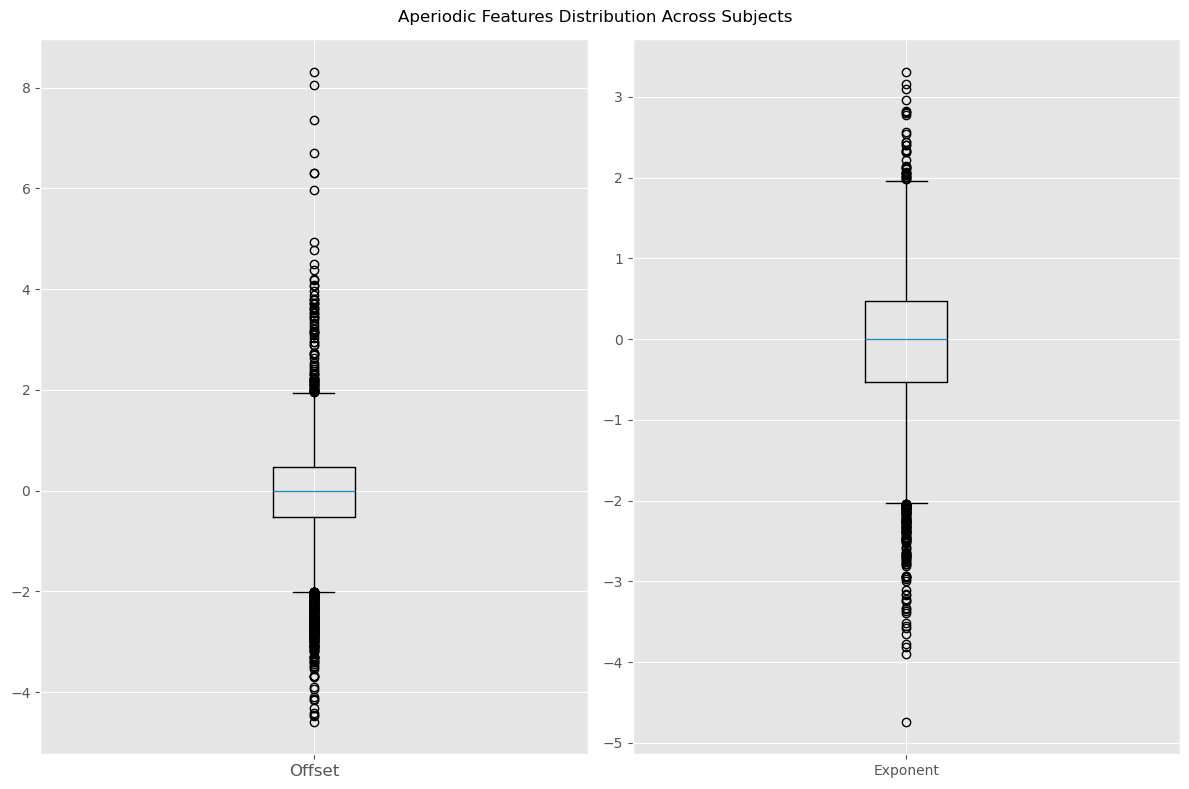

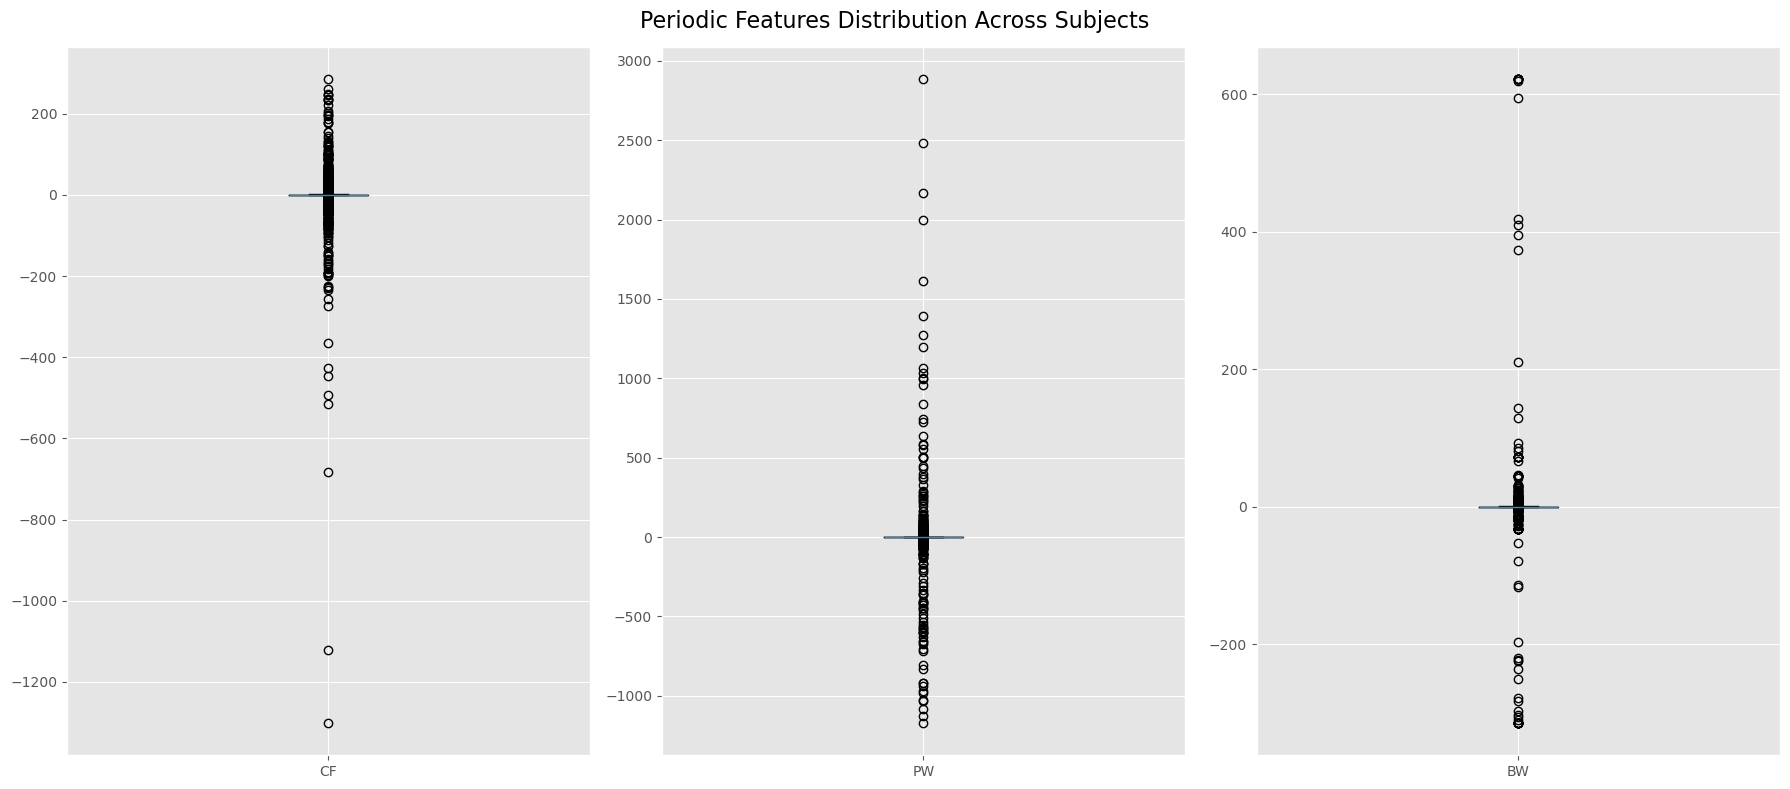

In [16]:
# Checkpoint - Data

# Aperiodic and periodic components distributions
aperiodic_components_plot(temp_names_X_train_df)
periodic_components_plot(temp_names_X_train_df)


# ML Model Training & Pipeline Create

## Functions - Classification Plots

In [17]:
# Function to Display The Model Fit Results

def print_search_results(search, duration):
    print('------- Search Results --------')
    all_search_results = pd.DataFrame(search.cv_results_)
    print(f"Score: {search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
    print(f'Search Took: {duration:.2f} seconds')
    print(f"Best Parameters: {search.best_params_}")
    top_n = 10
    print(f"Top {top_n} out of {len(all_search_results)} combinations:")
    display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].sort_values(by='rank_test_score').head(top_n))


In [18]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label=1)
    plt.show()

    plt.style.use('ggplot')

## Model Training - Random Forest & Transformed X

In [19]:
# Establish a Model Pipeline - Using Proessed Data
#

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
    ])

grid_params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'classifier__n_estimators': [150, 175],                       # Default 100. Number of trees
    'classifier__max_depth': [2, 5, 10],                          # Default none
    # 'randomforestclassifier__max_leaf_nodes': [5, 50],
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'randomforestclassifier__class_weight': ['balanced']            # Gives more importance to minority classes ... ?? Improves recall at the expense of precision
    } 

grid_search = GridSearchCV(
    model_pipeline, grid_params, 
    cv=5,
    scoring='precision'
    )


In [20]:
# Grid search run

start_time = time.perf_counter()
grid_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time


In [21]:
# Checkpoint - Pipeline

# print("Feature Extraction Pipeline Steps:")
# for name, step in model_pipeline.named_steps.items():
#     print(f"- {name}: {step}")

print("\nAll Pipeline Parameters")
for param, value in model_pipeline.get_params().items():
    print(f"- {param}: {value}")


All Pipeline Parameters
- memory: None
- steps: [('classifier', RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False))]
- transform_input: None
- verbose: False
- classifier: RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False)
- classifier__bootstrap: True
- classifier__ccp_alpha: 0.0
- classifier__class_weight: None
- classifier__criterion: gini
- classifier__max_depth: None
- classifier__max_features: sqrt
- classifier__max_leaf_nodes: None
- classifier__max_samples: None
- classifier__min_impurity_decrease: 0.0
- classifier__min_samples_leaf: 1
- classifier__min_samples_split: 2
- classifier__min_weight_fraction_leaf: 0.0
- classifier__monotonic_cst: None
- classifier__n_estimators: 100
- classifier__n_jobs: -1
- classifier__oob_score: False
- classifier__random_state: 42
- classifier__verbose: False
- classifier__warm_start: False


------- Search Results --------
Score: 0.7045. Mean: 0.6962 and STD 0.0072
Search Took: 9.81 seconds
Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__n_estimators': 150}
Top 10 out of 18 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
16,1,0.704520,0.084707,0.014377,"{'classifier__criterion': 'log_loss', 'classif..."
10,1,0.704520,0.085663,0.014632,"{'classifier__criterion': 'entropy', 'classifi..."
15,3,0.701905,0.098258,0.013872,"{'classifier__criterion': 'log_loss', 'classif..."
9,3,0.701905,0.096522,0.014345,"{'classifier__criterion': 'entropy', 'classifi..."
2,5,0.700949,0.086649,0.014892,"{'classifier__criterion': 'gini', 'classifier_..."
17,6,0.700925,0.100204,0.014832,"{'classifier__criterion': 'log_loss', 'classif..."
11,6,0.700925,0.101257,0.014936,"{'classifier__criterion': 'entropy', 'classifi..."
3,8,0.700775,0.093654,0.014514,"{'classifier__criterion': 'gini', 'classifier_..."
4,9,0.699791,0.086768,0.013860,"{'classifier__criterion': 'gini', 'classifier_..."
5,10,0.699053,0.097468,0.014589,"{'classifier__criterion': 'gini', 'classifier_..."


Accuracy: 0.7000
Precision: 0.6786
Recall: 1.0000
F1 Score 0.8085
Specificity: 0.1818
Hamming Loss 0.3000
ROC-AUC Score 0.8254
Gini Index: 0.6507


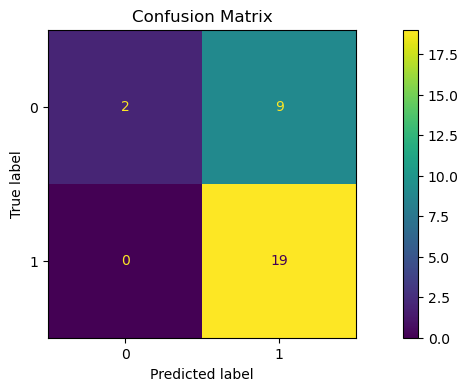

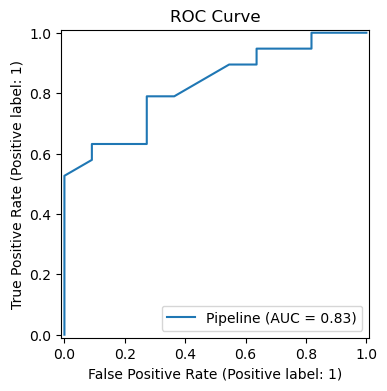

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__n_estimators': 150}
Best cross-validation score: 0.7045199956412771


In [22]:
# Grid search results
print_search_results(grid_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest = grid_search.best_estimator_
y_pred = model_randforest.predict(X_test_transformed)
classification_metrics(model_randforest, X_test_transformed, y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


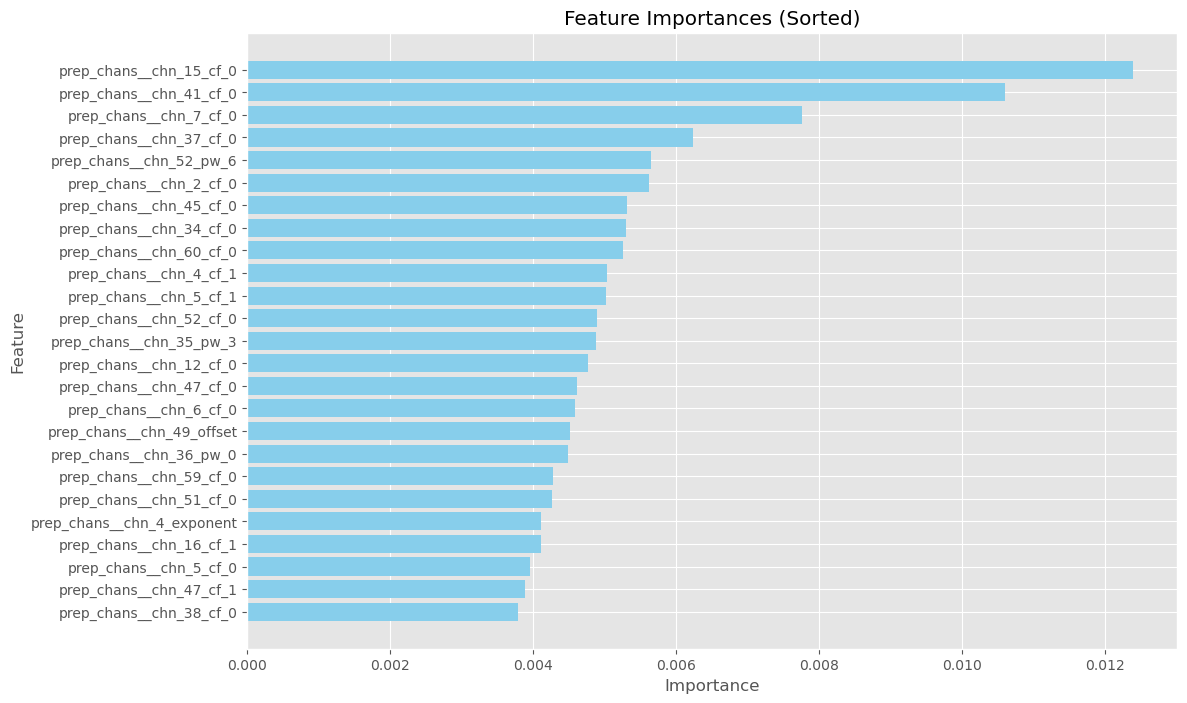

In [23]:
# Get feature importances
importances = model_randforest.named_steps['classifier'].feature_importances_

# Map feature importances to transformed feature names
transformed_feature_names = data_preprocessing.get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Keep only the top 25 most important features
importance_df = importance_df.head(25)

# print(importance_df)

# Plot the feature importances with names horizontally
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Model Training - Random Forest & Pipeline Test on X

In [24]:
# Establish a Model Pipeline
#

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('test', features_extraction_pl),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
    ])

grid_params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'classifier__n_estimators': [150, 175],                       # Default 100. Number of trees
    'classifier__max_depth': [2, 5, 10],                          # Default none
    # 'randomforestclassifier__max_leaf_nodes': [5, 50],
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'randomforestclassifier__class_weight': ['balanced']            # Gives more importance to minority classes ... ?? Improves recall at the expense of precision
    } 

grid_search = GridSearchCV(
    model_pipeline, grid_params, 
    cv=5,
    scoring='precision'
    )


In [25]:
# Grid search run

start_time = time.perf_counter()
# grid_search.fit(X_train_transformed, y_train)
grid_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time


/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['chn_50_cf_9' 'chn_50_pw_9' 'chn_50_bw_9']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['chn_50_cf_9' 'chn_50_pw_9' 'chn_50_bw_9']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['chn_50_cf_9' 'chn_50_pw_9' 'chn_50_bw_9']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/impute/_base.py:637: UserWarn

In [26]:
# Checkpoint - Pipeline

# print("Feature Extraction Pipeline Steps:")
# for name, step in model_pipeline.named_steps.items():
#     print(f"- {name}: {step}")

print("\nAll Pipeline Parameters")
for param, value in model_pipeline.get_params().items():
    print(f"- {param}: {value}")


All Pipeline Parameters
- memory: None
- steps: [('test', Pipeline(steps=[('features_extraction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['subject_id',
                                                   'chn_0_r_squared',
                                                   'chn_1_r_squared',
                                                   'chn_2_r_squared',
                                                   'chn_3_r_squared',
                                                   'chn_4_r_squared',
                                                   'chn_5_r_squared',
                                                   'chn_6_r_squared',
                                                   'chn_7_r_squared',
                                                   'chn_8_r_squared',
                                                   'chn_9_r_squared',
          

------- Search Results --------
Score: 0.7140. Mean: 0.6951 and STD 0.0086
Search Took: 18.49 seconds
Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__n_estimators': 150}
Top 10 out of 18 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
2,1,0.714026,0.191069,0.022150,"{'classifier__criterion': 'gini', 'classifier_..."
4,2,0.709013,0.185871,0.020977,"{'classifier__criterion': 'gini', 'classifier_..."
3,3,0.707702,0.186276,0.021519,"{'classifier__criterion': 'gini', 'classifier_..."
10,4,0.703824,0.166381,0.022449,"{'classifier__criterion': 'entropy', 'classifi..."
16,4,0.703824,0.178528,0.022268,"{'classifier__criterion': 'log_loss', 'classif..."
17,6,0.695929,0.183290,0.022353,"{'classifier__criterion': 'log_loss', 'classif..."
11,6,0.695929,0.177426,0.021584,"{'classifier__criterion': 'entropy', 'classifi..."
15,8,0.692513,0.187802,0.022833,"{'classifier__criterion': 'log_loss', 'classif..."
9,8,0.692513,0.180393,0.022413,"{'classifier__criterion': 'entropy', 'classifi..."
14,10,0.692080,0.167268,0.022330,"{'classifier__criterion': 'log_loss', 'classif..."


Accuracy: 0.7000
Precision: 0.6786
Recall: 1.0000
F1 Score 0.8085
Specificity: 0.1818
Hamming Loss 0.3000
ROC-AUC Score 0.8469
Gini Index: 0.6938


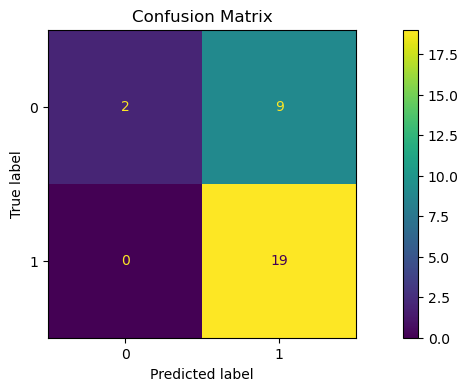

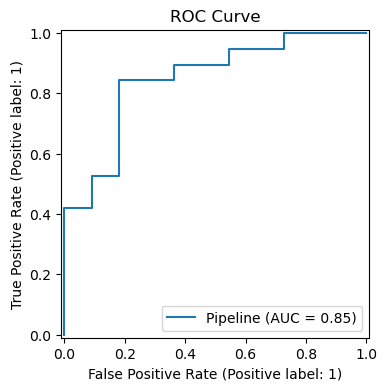

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__n_estimators': 150}
Best cross-validation score: 0.714025974025974


In [27]:
# Grid search results
print_search_results(grid_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest = grid_search.best_estimator_
y_pred = model_randforest.predict(X_test)
classification_metrics(model_randforest, X_test, y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


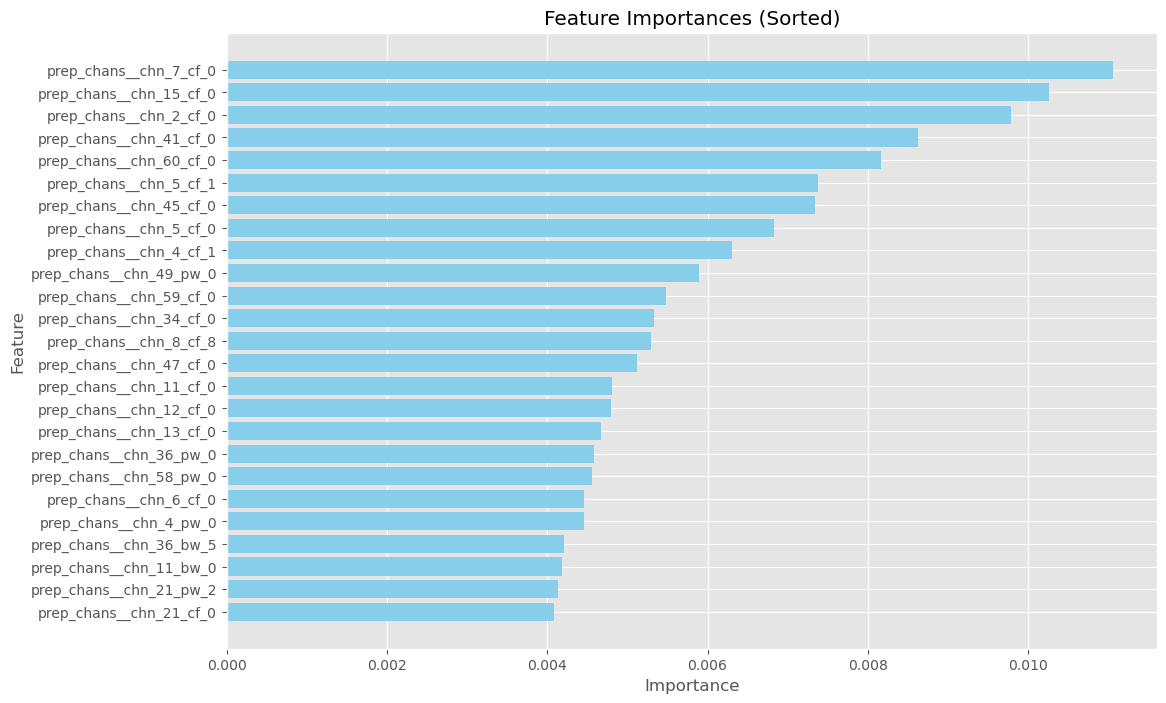

In [28]:
# Get feature importances
importances = model_randforest.named_steps['classifier'].feature_importances_

# Map feature importances to transformed feature names
transformed_feature_names = data_preprocessing.get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Keep only the top 25 most important features
importance_df = importance_df.head(25)

# print(importance_df)

# Plot the feature importances with names horizontally
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Test - Inspect the Data Transformation Executed During the Pipeline

In [29]:
# Access feature extraction output
feature_extractor = model_randforest.named_steps['test']
X_train_transformed_compare = feature_extractor.transform(X_train)


# Test - Full Model Run ..... it should be near perfect!?


Accuracy: 0.9396
Precision: 0.9174
Recall: 1.0000
F1 Score 0.9569
Specificity: 0.8163
Hamming Loss 0.0604
ROC-AUC Score 0.9929
Gini Index: 0.9857


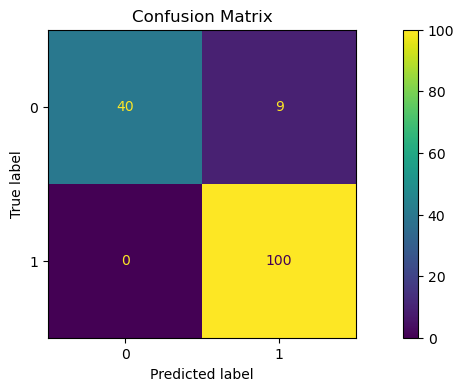

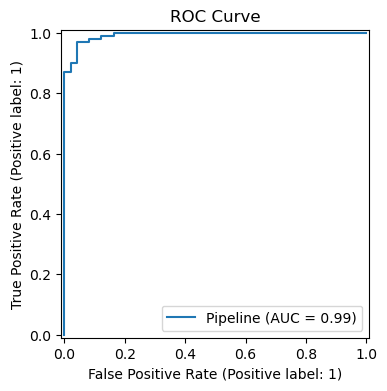

In [30]:
test_y_pred = model_randforest.predict(X)
classification_metrics(model_randforest, X, y, test_y_pred)


# WIP

In [31]:
# TODO: Complete a full pipeline, inc model?
# Create complete pipeline
# complete_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier())
# ])
# complete_pipeline.fit(X_train, y_train)

In [32]:
# TODO: save the pipeline / transformer
# from joblib import dump, load

# # Save the pipeline
# dump(pipeline, 'pipeline.joblib', compress=3)

# # Load the pipeline
# loaded_pipeline = load('pipeline.joblib')

# And meta data save


In [33]:
# Save the model

# file_path = os.path.join(ml_training_run_path, 'test_model.pkl')
# container = (model_randforest)
# with open(file_path, 'wb') as file:
#     pickle.dump(container, file)
